In [1]:
import torch
from torch import nn
from monotonenorm import MonotonicLayer, GroupSort
from matplotlib import pyplot as plt

In [28]:
# Example usage
class RMSNorm(nn.Module):
    def __init__(self, norm_shape):
        super().__init__()
        self.register_buffer("norm_shape", torch.tensor(norm_shape))
        self.register_parameter("weight", nn.Parameter(torch.ones(norm_shape)/self.norm_shape.sqrt()))
        self.register_parameter("bias", nn.Parameter(torch.zeros(norm_shape)))
        
    def forward(self, x):
        rms = torch.sqrt(torch.mean(x ** 2, axis=-1, keepdim=True)).clip(min=1)
        return (x / rms) * self.weight+ self.bias

input_dim = [3, 16, 256]
output_dim = [*input_dim[1:], 1]
model = nn.Sequential(
    *[
        layer
        for i in range(3)
        for layer in (
            MonotonicLayer(input_dim[i], output_dim[i]),
            GroupSort(2),
            # nn.LayerNorm(output_dim[i]),
            RMSNorm(output_dim[i]),
        )
    ][:-2]
)
model_base = nn.Sequential(
    *[
        layer
        for i in range(3)
        for layer in (nn.Linear(input_dim[i], output_dim[i]), GroupSort(2))
    ][:-1]
)

X = torch.randn(100, input_dim[0])
X[:, 1:] = 0
Y = model(X)
y_base = model_base(X)

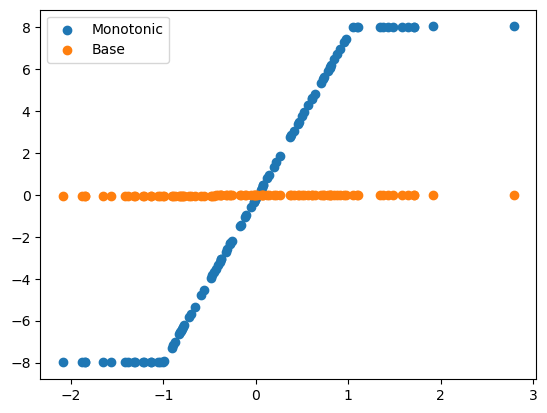

In [29]:
plt.scatter(X[:, 0], Y[:, 0].detach().numpy(), label="Monotonic")
plt.scatter(X[:, 0], y_base[:, 0].detach().numpy(), label="Base")
plt.legend()

**sanity check:** Let's take a look the RMS of intermediate representations 

In [19]:
x = X[:3, :]
for layer in model:
    x = layer(x)
    if isinstance(layer, MonotonicLayer):
        print(x)
        print("rms:", torch.sqrt(torch.mean(x ** 2, axis=-1)).detach())

tensor([[-0.0221,  0.1297,  0.1486, -0.1243,  0.1444, -0.3949, -0.1247, -0.3502,
         -0.0145,  0.1255, -0.2293, -0.2625, -0.0357,  0.1607, -0.2896, -0.2604],
        [-0.8841, -0.8011, -0.8047, -0.9642, -0.7603, -1.2410, -1.0362, -1.1528,
         -0.8256, -0.6761, -0.9760, -1.0994, -0.9168, -0.7939, -1.1702, -1.1920],
        [ 0.0248,  0.1803,  0.2004, -0.0787,  0.1935, -0.3489, -0.0751, -0.3066,
          0.0296,  0.1690, -0.1887, -0.2170,  0.0121,  0.2126, -0.2417, -0.2097]],
       grad_fn=<DivBackward0>)
rms: tensor([0.2071, 0.9709, 0.1934])
tensor([[-0.2173, -0.1463, -0.1709, -0.1943, -0.0973, -0.0788, -0.2675, -0.0838,
         -0.1454, -0.1825, -0.2339, -0.2484, -0.1570, -0.0973, -0.2709, -0.1595,
         -0.2870, -0.2904, -0.1004, -0.2252, -0.2606, -0.1822, -0.2381, -0.0669,
         -0.1300, -0.1419, -0.0638, -0.0781, -0.2803, -0.3014, -0.1906, -0.1606],
        [-1.9855, -1.8882, -1.9189, -1.9327, -1.8349, -1.8306, -2.0069, -1.8344,
         -1.8673, -1.9402, -1.9415,

## Synthetic toy data
Let's train on some toy data to see how the model works. We'll use a simple regression problem with two input two outputs.

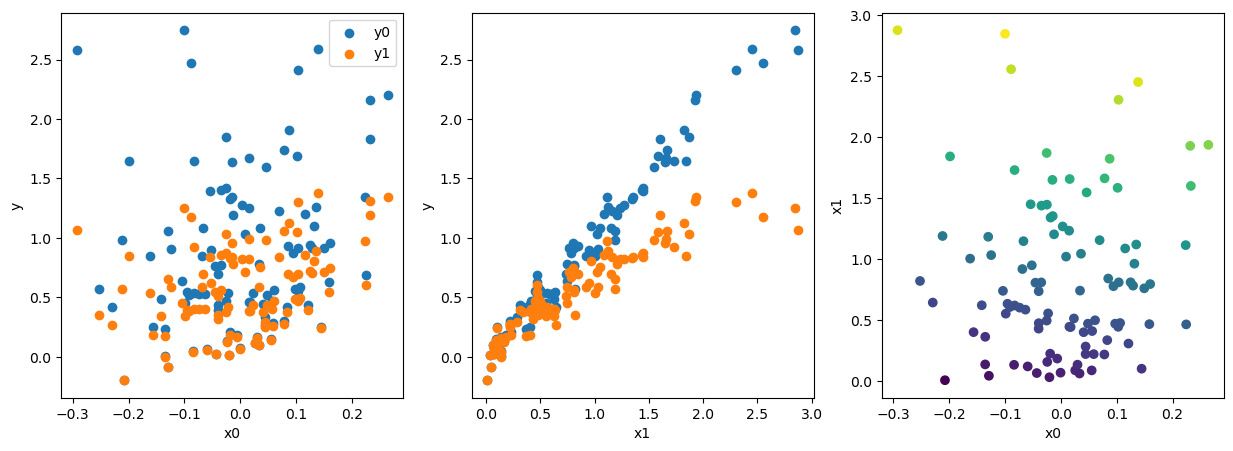

In [20]:
X  = torch.randn(100, 2)
X[:, 0] = X[:, 0] * 0.1
X[:, 1] = torch.abs(X[:, 1])
y = torch.vstack([X[:,0] + X[:,1], X[:,0] + torch.log(X[:,1] + 1)]).T

def plot_data():
    # plot the data
    fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(15, 5))
    ax0.scatter(X[:,0], y[:,0], label="y0")
    ax0.scatter(X[:,0], y[:,1], label="y1")
    ax0.set_xlabel("x0")
    ax0.set_ylabel("y")

    ax1.scatter(X[:, 1], y[:, 0], label="y0")
    ax1.scatter(X[:, 1], y[:, 1], label="y1")
    ax1.set_xlabel("x1")
    ax1.set_ylabel("y")

    # plot y[0] as a function of x[0] and x[1]
    ax2.scatter(X[:, 0], X[:, 1], c=y[:, 0], label="y0")
    ax2.set_xlabel("x0")
    ax2.set_ylabel("x1")
    ax0.legend()
    return fig, (ax0, ax1, ax2)
plot_data()
plt.show()

Now we train the models

In [21]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123)
device = "cuda:0"
X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

In [22]:
input_dim = [2, 32, 32]
output_dim = [*input_dim[1:], 2]
model = nn.Sequential(
    *[
        layer
        for i in range(3)
        for layer in (
            MonotonicLayer(input_dim[i], output_dim[i]),
            GroupSort(2),
            # nn.LayerNorm(output_dim[i]),
            RMSNorm(output_dim[i]),
        )
    ][:-2]
).to(device)
model_base = nn.Sequential(
    *[
        layer
        for i in range(3)
        for layer in (nn.Linear(input_dim[i], output_dim[i]), GroupSort(2))
    ][:-1]
).to(device)


In [23]:
import tqdm.notebook as tqdm

def train_model(model, X_train, y_train, X_test, y_test):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

    for epoch in (pbar:=tqdm.trange(10000)):
        optimizer.zero_grad()
        y_pred = model(X_train)
        loss = torch.mean((y_pred - y_train) ** 2)
        loss.backward()
        optimizer.step()
        with torch.no_grad():
            y_pred_test = model(X_test)
            loss_test = torch.mean((y_pred_test - y_test) ** 2)
            pbar.set_description(f"loss: {loss.item():.3f}, test loss: {loss_test.item():.3f}")

    
    return model

In [24]:
train_model(model, X_train, y_train, X_test, y_test)
train_model(model_base, X_train, y_train, X_test, y_test)
print("Done!")
# plot the data

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Sequential(
  (0): Linear(in_features=2, out_features=32, bias=True)
  (1): GroupSort(num_groups: 2)
  (2): Linear(in_features=32, out_features=32, bias=True)
  (3): GroupSort(num_groups: 2)
  (4): Linear(in_features=32, out_features=2, bias=True)
)

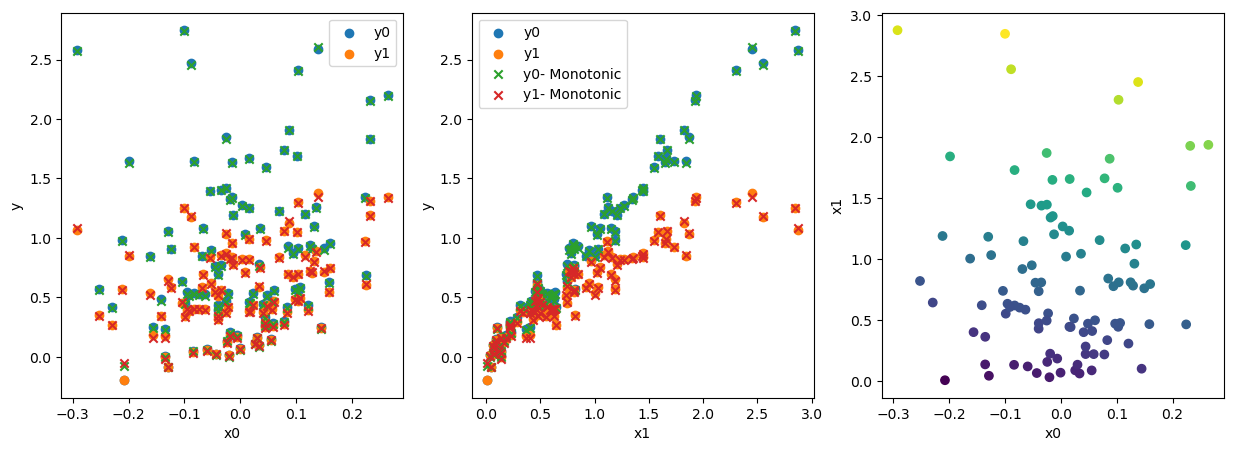

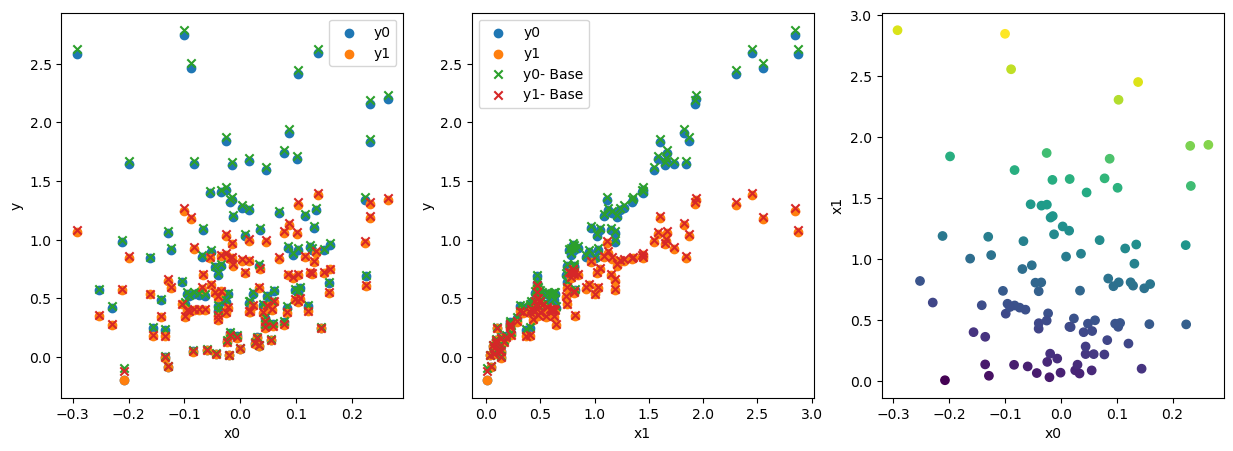

In [25]:
fig, (ax0, ax1, ax2) = plot_data()
# plot the model
def plot_model(model, name):
    pred = model(X.to(device)).detach().cpu().numpy()
    ax0.scatter(X[:, 0], pred[:, 0], label=f"y0- {name}", marker="x")
    ax0.scatter(X[:, 0], pred[:, 1], label=f"y1- {name}", marker="x")
    ax1.scatter(X[:, 1], pred[:, 0], label=f"y0- {name}", marker="x")
    ax1.scatter(X[:, 1], pred[:, 1], label=f"y1- {name}", marker="x")
    ax1.legend()
plot_model(model, "Monotonic")
plt.show()
fig, (ax0, ax1, ax2) = plot_data()
plot_model(model_base, "Base")